# 基于文本挖掘的企业隐患排查质量分析模型 
 https://www.sodic.com.cn/competitions/900010
 
 
### 1 赛题名称
基于文本挖掘的企业隐患排查质量分析模型

### 2 赛题背景
企业自主填报安全生产隐患，对于将风险消除在事故萌芽阶段具有重要意义。企业在填报隐患时，往往存在不认真填报的情况，“虚报、假报”隐患内容，增大了企业监管的难度。采用大数据手段分析隐患内容，找出不切实履行主体责任的企业，向监管部门进行推送，实现精准执法，能够提高监管手段的有效性，增强企业安全责任意识。

### 3 赛题任务
本赛题提供企业填报隐患数据，参赛选手需通过智能化手段识别其中是否存在“虚报、假报”的情况。

 看清赛题很关键，大家需要好好理解赛题目标之后，再去做题，可以避免很多弯路。
 
 
### 4 数据简介
本赛题数据集为脱敏后的企业填报自查隐患记录。

数据说明
训练集数据包含“【id、level_1（一级标准）、level_2（二级标准）、level_3（三级标准）、level_4（四级标准）、content（隐患内容）和label（标签）】”共7个字段。
 其中“id”为主键，无业务意义；“一级标准、二级标准、三级标准、四级标准”为《深圳市安全隐患自查和巡查基本指引（2016年修订版）》规定的排查指引，一级标准对应不同隐患类型，二至四级标准是对一级标准的细化，企业自主上报隐患时，根据不同类型隐患的四级标准开展隐患自查工作；“隐患内容”为企业上报的具体隐患；“标签”标识的是该条隐患的合格性，“1”表示隐患填报不合格，“0”表示隐患填报合格。

> 预测结果文件results.csv

|列名|说明|
|----|----|
|id|企业号|
|label|正负样本分类|




- 文件名：results.csv，utf-8编码
- 参赛者以csv/json等文件格式，提交模型结果，平台进行在线评分，实时排名。


### 5 评测标准
本赛题采用F1 -score作为模型评判标准。


### 6 赛题解析笔记
[手把手教你搭建Bert文本分类模型，快点看过来吧！](https://ask.qcloudimg.com/http-save/yehe-1293914/60c0a69c2d5cdba9611dc4c0b3a47804.png?imageView2/2/w/1620)

## 1 导入工具包

In [ ]:
#  pip install -i https://pypi.tuna.tsinghua.edu.cn/simple transformers

In [25]:
# 导入transformers
import transformers
# from transformers import BertModel, BertTokenizer,BertConfig, AdamW, get_linear_schedule_with_warmup

from transformers import AutoModel, AutoTokenizer,AutoConfig, AdamW, get_linear_schedule_with_warmup

# 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# 常用包
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap


%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# 固定随机种子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
torch.cuda.is_available()

True

## 2 加载数据

In [ ]:
train=pd.read_csv('/home/mw/input/task026741/sub.csv')
test=pd.read_csv('/home/mw/input/task026741/test.csv')
sub=pd.read_csv('/home/mw/input/task026741/train.csv')

In [4]:
# train=pd.read_csv('data/02/train.csv')
# test=pd.read_csv('data/02/test.csv')
# sub=pd.read_csv('data/02/sub.csv')

print("train.shape,test.shape,sub.shape",train.shape,test.shape,sub.shape)

train.shape,test.shape,sub.shape (12000, 7) (18000, 6) (18000, 2)


In [5]:
# 查看前三行
train.head(3)

,id,level_1,level_2,level_3,level_4,content,label
0,0,工业/危化品类（现场）—2016版,（二）电气安全,6、移动用电产品、电动工具及照明,1、移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0
1,1,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,一般,1
2,2,工业/危化品类（现场）—2016版,（一）消防检查,2、防火检查,6、重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0


### 2.1  查看缺失值

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       12000 non-null  int64 
 1   level_1  12000 non-null  object
 2   level_2  12000 non-null  object
 3   level_3  12000 non-null  object
 4   level_4  12000 non-null  object
 5   content  11998 non-null  object
 6   label    12000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 656.4+ KB


In [6]:
train[train['content'].isna()] # content 非常重要的字段

,id,level_1,level_2,level_3,level_4,content,label
6193,6193,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,3、消防设施、器材和消防安全标志是否在位、完整；,NaN,1
9248,9248,工业/危化品类（现场）—2016版,（一）消防检查,1、防火巡查,4、常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；,NaN,1


In [7]:
test.info() # 4 条content为空

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       18000 non-null  int64 
 1   level_1  18000 non-null  object
 2   level_2  18000 non-null  object
 3   level_3  18000 non-null  object
 4   level_4  18000 non-null  object
 5   content  17996 non-null  object
dtypes: int64(1), object(5)
memory usage: 843.9+ KB


In [8]:
print("train null nums")
print(train.shape[0]-train.count())
print("test null nums")
print(test.shape[0]-test.count())

train null nums
id         0
level_1    0
level_2    0
level_3    0
level_4    0
content    2
label      0
dtype: int64
test null nums
id         0
level_1    0
level_2    0
level_3    0
level_4    0
content    4
dtype: int64


### 2.2 标签分布

> tip:NLP所有任务，首先要看下答案或者标签的分布
> 分类任务，每个类别分布；回归任务，具体数值分布；NER任务，需要标注标签分布。。
> 

In [9]:
train['label'].value_counts()

0    10712
1     1288
Name: label, dtype: int64

Text(0.5, 0, 'label count')

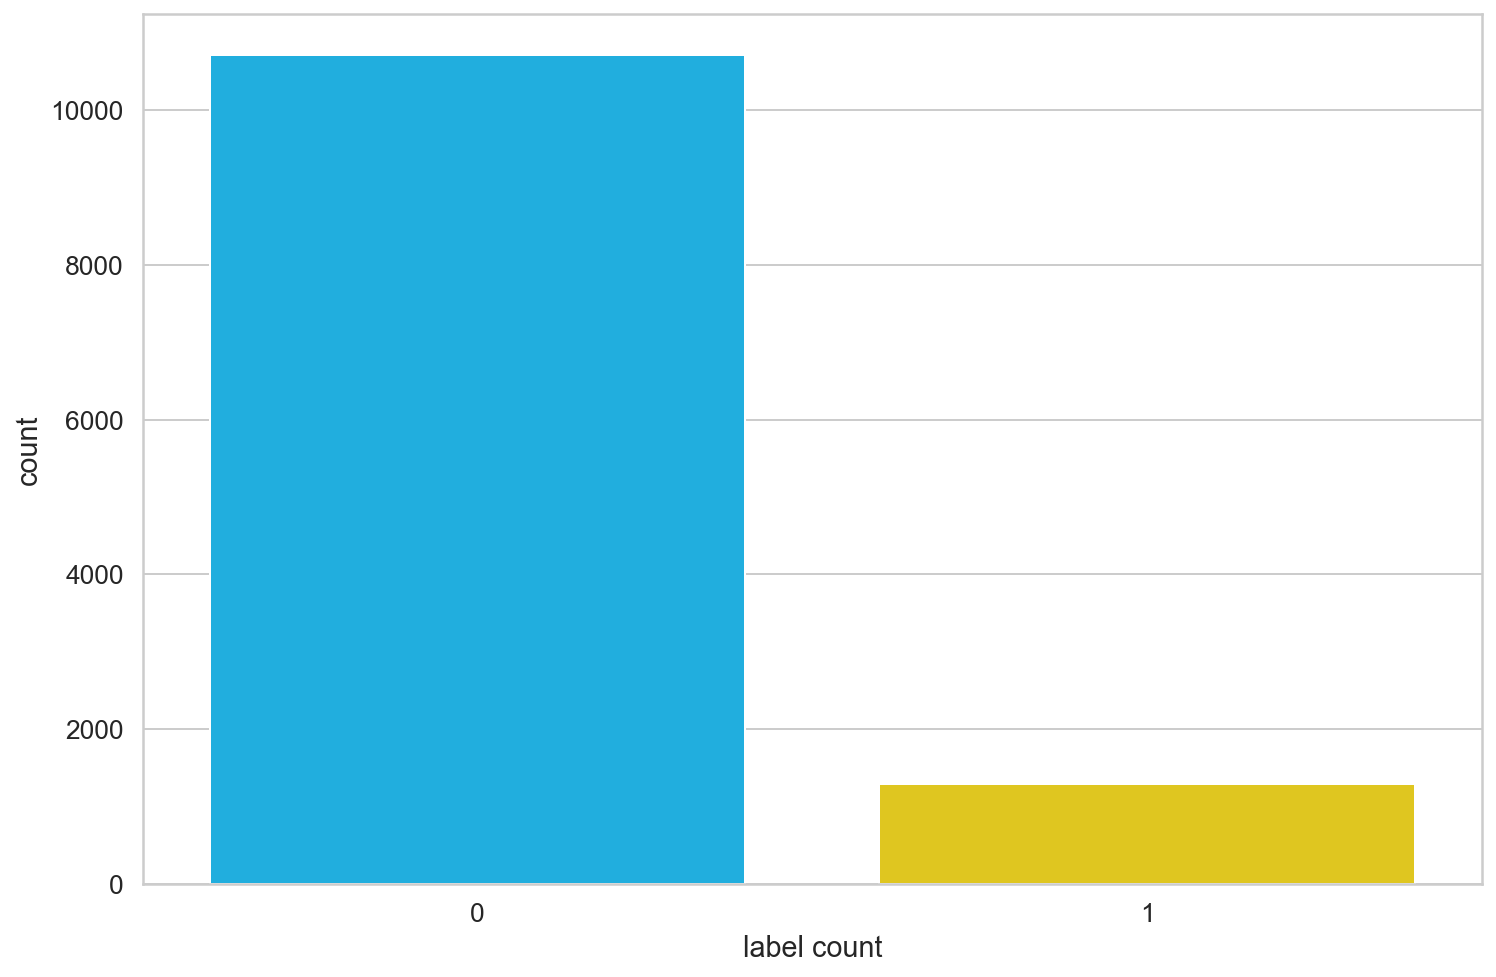

In [47]:
sns.countplot(train.label)
plt.xlabel('label count')

In [11]:
1288/10712

0.12023898431665422

## 3 数据预处理

In [12]:
# 填充缺失值
train['content']=train['content'].fillna('空值')
test['content']=test['content'].fillna('空值')

In [13]:
train['level_1']=train['level_1'].apply(lambda x:x.split('（')[0])
train['level_2']=train['level_2'].apply(lambda x:x.split('）')[-1])
train['level_3']=train['level_3'].apply(lambda x:re.split(r'[0-9]、',x)[-1])
train['level_4']=train['level_4'].apply(lambda x:re.split(r'[0-9]、',x)[-1])

test['level_1']=test['level_1'].apply(lambda x:x.split('（')[0])
test['level_2']=test['level_2'].apply(lambda x:x.split('）')[-1])
test['level_3']=test['level_3'].apply(lambda x:re.split(r'[0-9]、',x)[-1])
test['level_4']=test['level_4'].apply(lambda x:re.split(r'[0-9]、',x)[-1])

In [14]:
train

,id,level_1,level_2,level_3,level_4,content,label
0,0,工业/危化品类,电气安全,移动用电产品、电动工具及照明,移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0
1,1,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,一般,1
2,2,工业/危化品类,消防检查,防火检查,重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0
3,3,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,消防通道有货物摆放 清理不及时,0
4,4,工业/危化品类,消防检查,防火巡查,常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；,防火门打开状态,0
...,...,...,...,...,...,...,...
11995,11995,商贸服务教文卫类,安全教育培训,员工安全教育,制定安全教育培训计划，确保全员参与培训，并建立安全培训档案。,个别员工对消防栓的使用不熟练\r\n,0
11996,11996,工业/危化品类,电气安全,电气线路及电源插头插座,电源插座、电源插头应按规定正确接线。,化验室超净台照明电源线防护不足，且检测台金属架未安装漏电接地保护线。整改措施：更换照明灯为前...,0
11997,11997,工业/危化品类,机械设备安全防护,人身防护,皮带轮、齿轮、凸轮、曲柄连杆机构等外露的转动和运动部件应有防护罩。,电箱、马达，没有防护罩，现在整改,0
11998,11998,工业/危化品类,作业环境,通风与照明,作业场所通风良好。,D1部车间二楼配胶房排风扇未开启。,0


In [17]:
# train['text']=train['content']+' '+train['level_1']+' '+train['level_2']+' '+train['level_3']+' '+train['level_4']
# test['text']=test['content']+' '+test['level_1']+' '+test['level_2']+' '+test['level_3']+' '+test['level_4']
train['text']=train['content']+'[SEP]'+train['level_1']+'[SEP]'+train['level_2']+'[SEP]'+train['level_3']+'[SEP]'+train['level_4']
test['text']=test['content']+'[SEP]'+test['level_1']+'[SEP]'+test['level_2']+'[SEP]'+test['level_3']+'[SEP]'+test['level_4']

In [18]:
train.head()

,id,level_1,level_2,level_3,level_4,content,label,text
0,0,工业/危化品类,电气安全,移动用电产品、电动工具及照明,移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.",0,"使用移动手动电动工具,外接线绝缘皮破损,应停止使用.[SEP]工业/危化品类[SEP]电气安..."
1,1,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,一般,1,一般[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]消防设施、器材和消...
2,2,工业/危化品类,消防检查,防火检查,重点工种人员以及其他员工消防知识的掌握情况；,消防知识要加强,0,消防知识要加强[SEP]工业/危化品类[SEP]消防检查[SEP]防火检查[SEP]重点工种...
3,3,工业/危化品类,消防检查,防火巡查,消防设施、器材和消防安全标志是否在位、完整；,消防通道有货物摆放 清理不及时,0,消防通道有货物摆放 清理不及时[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[...
4,4,工业/危化品类,消防检查,防火巡查,常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；,防火门打开状态,0,防火门打开状态[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]常闭式防...


### 3.1 文本长度分布

In [19]:
train['text_len']=train['text'].map(len)

In [20]:
train['text'].map(len).describe()# 298-12=286

count    12000.000000
mean        80.439833
std         21.913662
min         43.000000
25%         66.000000
50%         75.000000
75%         92.000000
max        298.000000
Name: text, dtype: float64

In [21]:
test['text'].map(len).describe() # 520-12=518

count    18000.000000
mean        80.762611
std         22.719823
min         43.000000
25%         66.000000
50%         76.000000
75%         92.000000
max        520.000000
Name: text, dtype: float64

<AxesSubplot:ylabel='Density'>

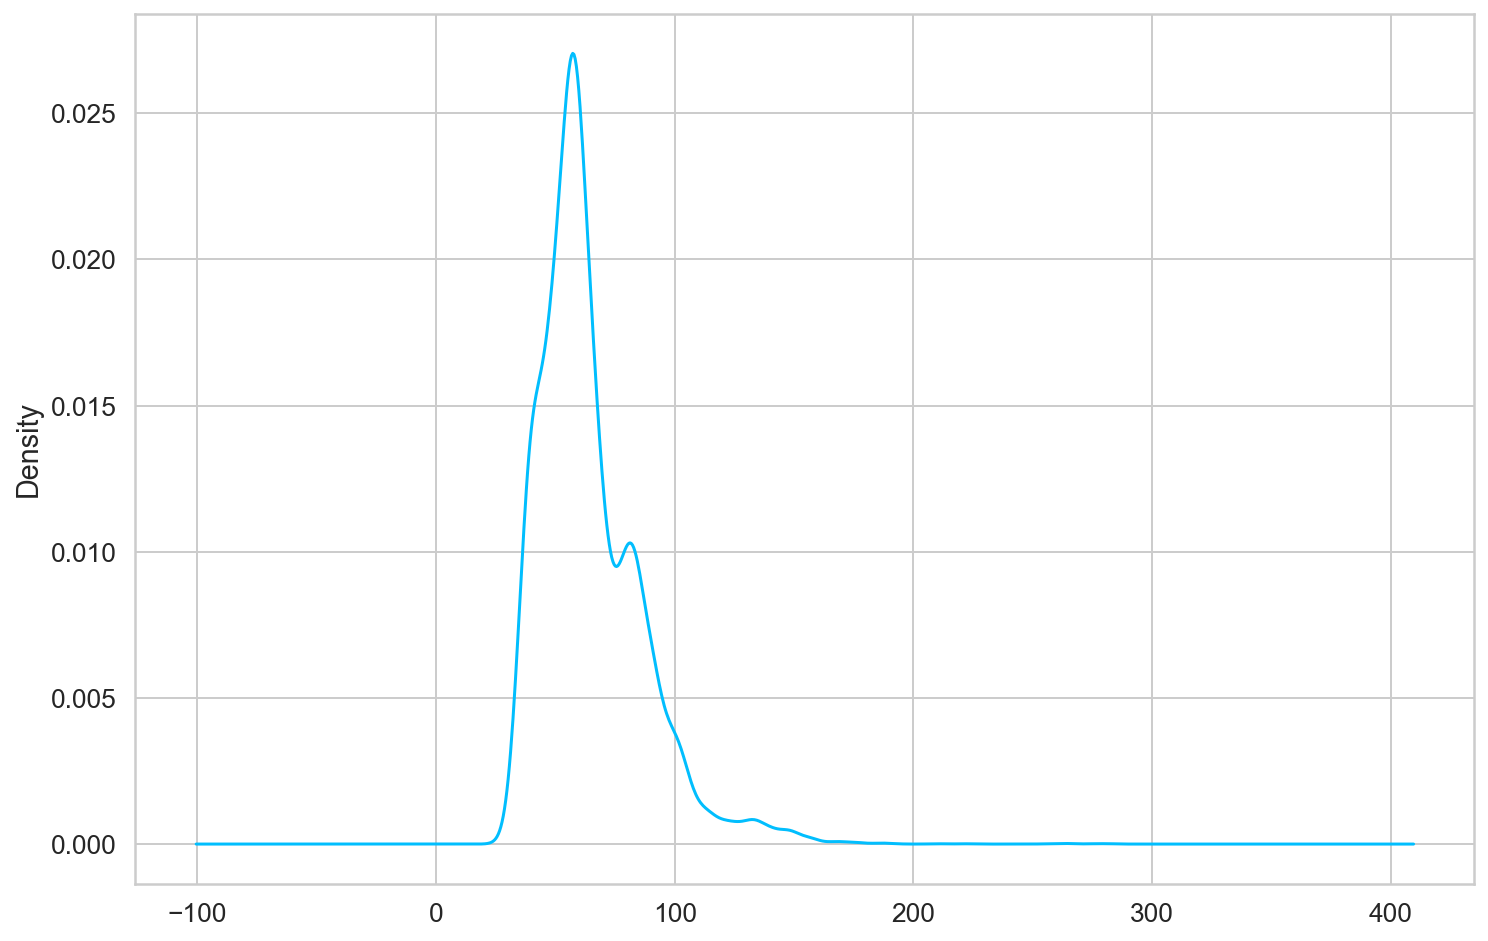

In [57]:
train['text_len'].plot(kind='kde')

In [24]:
sum(train['text_len']>100) # text文本长度大于100的个数
sum(train['text_len']>200) # text文本长度大于200的个数

11

In [23]:
1878/len(train)

0.1565

## 4 认识Tokenizer
### 4.1 将文本映射为id表示

In [26]:
PRE_TRAINED_MODEL_NAME = 'bert-base-chinese'
# PRE_TRAINED_MODEL_NAME = 'hfl/chinese-roberta-wwm-ext'
# PRE_TRAINED_MODEL_NAME = 'hfl/chinese-roberta-wwm'

# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
# tokenizer = BertTokenizer.from_pretrained('C:\\Users\\yanqiang\\Desktop\\bert-base-chinese')

In [27]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-chinese', vocab_size=21128, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

- 可以看到`BertTokenizer`的词表大小为21128
- 特殊符号为`special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}`

我们尝试使用`BertTokenizer`进行分词


In [28]:
sample_txt = '今天早上9点半起床，我在学习预训练模型的使用.'

In [29]:
len(sample_txt)

23

In [30]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'文本为: {sample_txt}')
print(f'分词的列表为: {tokens}')
print(f'词对应的唯一id: {token_ids}')

文本为: 今天早上9点半起床，我在学习预训练模型的使用.
分词的列表为: ['今', '天', '早', '上', '9', '点', '半', '起', '床', '，', '我', '在', '学', '习', '预', '训', '练', '模', '型', '的', '使', '用', '.']
词对应的唯一id: [791, 1921, 3193, 677, 130, 4157, 1288, 6629, 2414, 8024, 2769, 1762, 2110, 739, 7564, 6378, 5298, 3563, 1798, 4638, 886, 4500, 119]


### 4.2 特殊符号

In [31]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [32]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [33]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [34]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [35]:
tokenizer.mask_token, tokenizer.mask_token_id

('[MASK]', 103)

可以使用 [`encode_plus()` ](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plu)对句子进行分词，添加特殊符号

In [36]:
encoding=tokenizer.encode_plus(
    sample_txt,
    # sample_txt_another,
    max_length=32,
    add_special_tokens=True,# [CLS]和[SEP]
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',# Pytorch tensor张量

)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
F:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [37]:
encoding

{'input_ids': tensor([[ 101,  791, 1921, 3193,  677,  130, 4157, 1288, 6629, 2414, 8024, 2769,
         1762, 2110,  739, 7564, 6378, 5298, 3563, 1798, 4638,  886, 4500,  119,
          102,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0]])}

token ids的长度为32的张量

In [29]:
print(len(encoding['input_ids'][0]))

32


attention mask具有同样的长度

In [38]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0]])

我们将ids反转为词语，可以打印下每个字符是什么？

In [39]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 '今',
 '天',
 '早',
 '上',
 '9',
 '点',
 '半',
 '起',
 '床',
 '，',
 '我',
 '在',
 '学',
 '习',
 '预',
 '训',
 '练',
 '模',
 '型',
 '的',
 '使',
 '用',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### 4.2 选取文本最大长度

In [40]:
token_lens = []

for txt in train.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

F:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


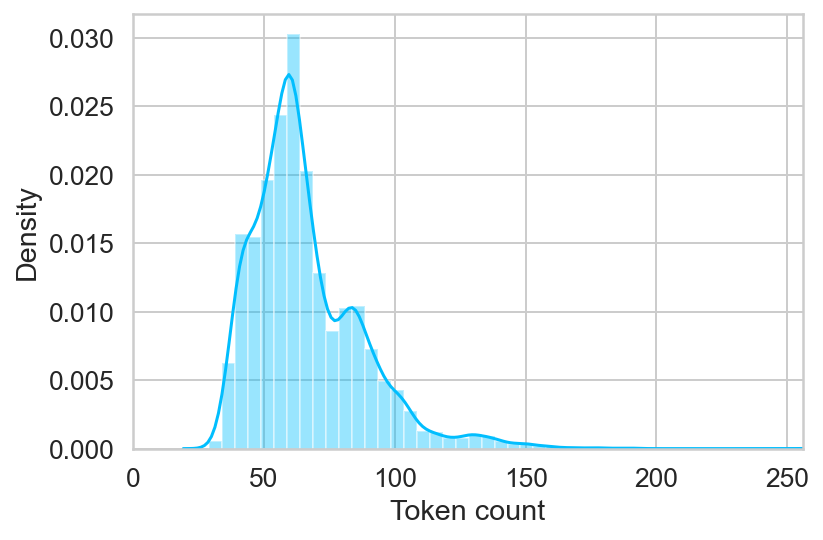

In [41]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

可以看到大多数文本的ids长度在100以内，我们设置最大长度为160

In [42]:
MAX_LEN = 160

## 5 构建数据集

### 5.1 自定义数据集

In [46]:
class EnterpriseDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
#         print(encoding['input_ids'])
        return {
            'texts':text,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            # toeken_type_ids:0
            'labels':torch.tensor(label,dtype=torch.long)
        }
        

### 5.2 划分数据集并创建生成器

In [43]:
df_train, df_test = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((10800, 9), (600, 9), (600, 9))

In [44]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=EnterpriseDataset(
        texts=df['text'].values,
        labels=df['label'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
#         num_workers=4 # windows多线程
    )

In [47]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [48]:
next(iter(train_data_loader))

F:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'texts': ['指示标识不清楚[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '发现本月有灭火器过期，已安排购买灭火器更换[SEP]商贸服务教文卫类[SEP]消防检查[SEP]防火检查[SEP]灭火器材配置及有效情况。',
  '安全出口标志灯有一个有故障，已买回安装改正。[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '堵了消防通道[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；'],
 'input_ids': tensor([[ 101, 2900, 4850, 3403, 6399,  679, 3926, 3504,  102, 2339,  689,  120,
          1314, 1265, 1501, 5102,  102, 3867, 7344, 3466, 3389,  102, 7344, 4125,
          2337, 3389,  102, 2128, 1059, 1139, 1366,  510, 4541, 3141, 6858, 6887,
          3221, 1415, 4517, 6858, 8024, 2128, 1059, 4541, 3141, 2900, 4850, 3403,
          2562,  510, 2418, 2593, 4212, 3209, 3221, 1415, 2130, 1962, 8039,  102,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0

In [49]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [50]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([4, 160])
torch.Size([4, 160])
torch.Size([4])


## 6 基于Huggingface 的企业隐患识别模型构建

In [51]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [53]:
encoding

{'input_ids': tensor([[ 101,  791, 1921, 3193,  677,  130, 4157, 1288, 6629, 2414, 8024, 2769,
         1762, 2110,  739, 7564, 6378, 5298, 3563, 1798, 4638,  886, 4500,  119,
          102,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0]])}

In [54]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask'],
    return_dict = False
)

In [55]:
last_hidden_state # 每个token的向量表示

tensor([[[ 0.8880,  0.1987,  1.3610,  ..., -0.5096,  0.3742, -0.2368],
         [-0.0747,  0.3148,  1.4699,  ..., -1.0238, -0.0518, -0.0557],
         [ 1.0133, -0.6058,  1.0152,  ...,  0.3536,  1.1091, -0.1179],
         ...,
         [ 0.4613,  0.4155, -0.4329,  ...,  0.1605, -0.3617, -0.2294],
         [ 0.4403,  0.4763, -0.5568,  ...,  0.2216, -0.3297, -0.3064],
         [ 0.4437,  0.3844, -0.4880,  ...,  0.0670, -0.5105, -0.2472]]],
       grad_fn=<NativeLayerNormBackward>)

In [56]:
pooled_output

tensor([[ 0.9999,  0.9998,  0.9989,  0.9629,  0.3075, -0.1866, -0.9904,  0.8628,
          0.9710, -0.9993,  1.0000,  1.0000,  0.9312, -0.9394,  0.9998, -0.9999,
          0.0417,  0.9999,  0.9458,  0.3190,  1.0000, -1.0000, -0.9062, -0.9048,
          0.1764,  0.9983,  0.9346, -0.8122, -0.9999,  0.9996,  0.7879,  0.9999,
          0.8475, -1.0000, -1.0000,  0.9413, -0.8260,  0.9889, -0.4976, -0.9857,
         -0.9955, -0.9580,  0.5833, -0.9996, -0.8932,  0.8563, -1.0000, -0.9999,
          0.9719,  0.9999, -0.7430, -0.9993,  0.9756, -0.9754,  0.2991,  0.8933,
         -0.9991,  0.9987,  1.0000,  0.4156,  0.9992, -0.9452, -0.8020, -0.9999,
          1.0000, -0.9964, -0.9900,  0.4365,  1.0000,  1.0000, -0.9400,  0.8794,
          1.0000,  0.9105, -0.6616,  1.0000, -0.9999,  0.6892, -1.0000, -0.9817,
          1.0000,  0.9957, -0.8844, -0.8248, -0.9921, -0.9999, -0.9998,  1.0000,
          0.5228,  0.1297,  0.9932, -0.9999, -1.0000,  0.9993, -0.9996, -0.9948,
         -0.9561,  0.9996, -

In [154]:
last_hidden_state.shape # 每个token的向量表示

torch.Size([1, 32, 768])

In [155]:
pooled_output.shape # CLS的向量表示

torch.Size([1, 768])

In [57]:
bert_model.config.hidden_size

768

In [58]:
pooled_output.shape
# 整体句子表示

torch.Size([1, 768])

In [59]:
class EnterpriseDangerClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EnterpriseDangerClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # 两个类别
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        output = self.drop(pooled_output) # dropout
        return self.out(output)

In [60]:
class_names=[0,1]

In [61]:
model = EnterpriseDangerClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [62]:
data

{'texts': ['指示标识不清楚[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '发现本月有灭火器过期，已安排购买灭火器更换[SEP]商贸服务教文卫类[SEP]消防检查[SEP]防火检查[SEP]灭火器材配置及有效情况。',
  '安全出口标志灯有一个有故障，已买回安装改正。[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '堵了消防通道[SEP]工业/危化品类[SEP]消防检查[SEP]防火巡查[SEP]安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；'],
 'input_ids': tensor([[ 101, 2900, 4850, 3403, 6399,  679, 3926, 3504,  102, 2339,  689,  120,
          1314, 1265, 1501, 5102,  102, 3867, 7344, 3466, 3389,  102, 7344, 4125,
          2337, 3389,  102, 2128, 1059, 1139, 1366,  510, 4541, 3141, 6858, 6887,
          3221, 1415, 4517, 6858, 8024, 2128, 1059, 4541, 3141, 2900, 4850, 3403,
          2562,  510, 2418, 2593, 4212, 3209, 3221, 1415, 2130, 1962, 8039,  102,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0

In [63]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 160])
torch.Size([4, 160])


In [65]:
model(input_ids, attention_mask)

tensor([[-0.3011, -0.3009],
        [ 0.2871,  0.1841],
        [ 0.2703, -0.0926],
        [-0.3193, -0.1487]], device='cuda:0', grad_fn=<AddmmBackward>)

In [64]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.6495, 0.3505],
        [0.6752, 0.3248],
        [0.7261, 0.2739],
        [0.4528, 0.5472]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## 7 模型训练

In [66]:
EPOCHS = 10 # 训练轮数

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

F:\ProgramData\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [67]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train() # train模式
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [68]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() # 验证预测模式

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [167]:

history = defaultdict(list) # 记录10轮loss和acc
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------
Train loss 0.49691140200114914 accuracy 0.8901851851851852
Val   loss 0.40999091763049367 accuracy 0.9

Epoch 2/10
----------
Train loss 0.3062430267758383 accuracy 0.9349999999999999
Val   loss 0.20030112245275328 accuracy 0.9650000000000001

Epoch 3/10
----------
Train loss 0.18264216477097728 accuracy 0.9603703703703703
Val   loss 0.18755523634143173 accuracy 0.9650000000000001

Epoch 4/10
----------
Train loss 0.15700688022613543 accuracy 0.9693518518518518
Val   loss 0.20371213133369262 accuracy 0.9633333333333334

Epoch 5/10
----------
Train loss 0.1627817107436756 accuracy 0.9668518518518519
Val   loss 0.16456402061972766 accuracy 0.9683333333333334

Epoch 6/10
----------
Train loss 0.15311389193888453 accuracy 0.9721296296296296
Val   loss 0.1188539441426595 accuracy 0.9783333333333334

Epoch 7/10
----------
Train loss 0.13947947008179012 accuracy 0.9734259259259259
Val   loss 0.12033098526764661 accuracy 0.9783333333333334

Epoch 8/10
----------
Train los

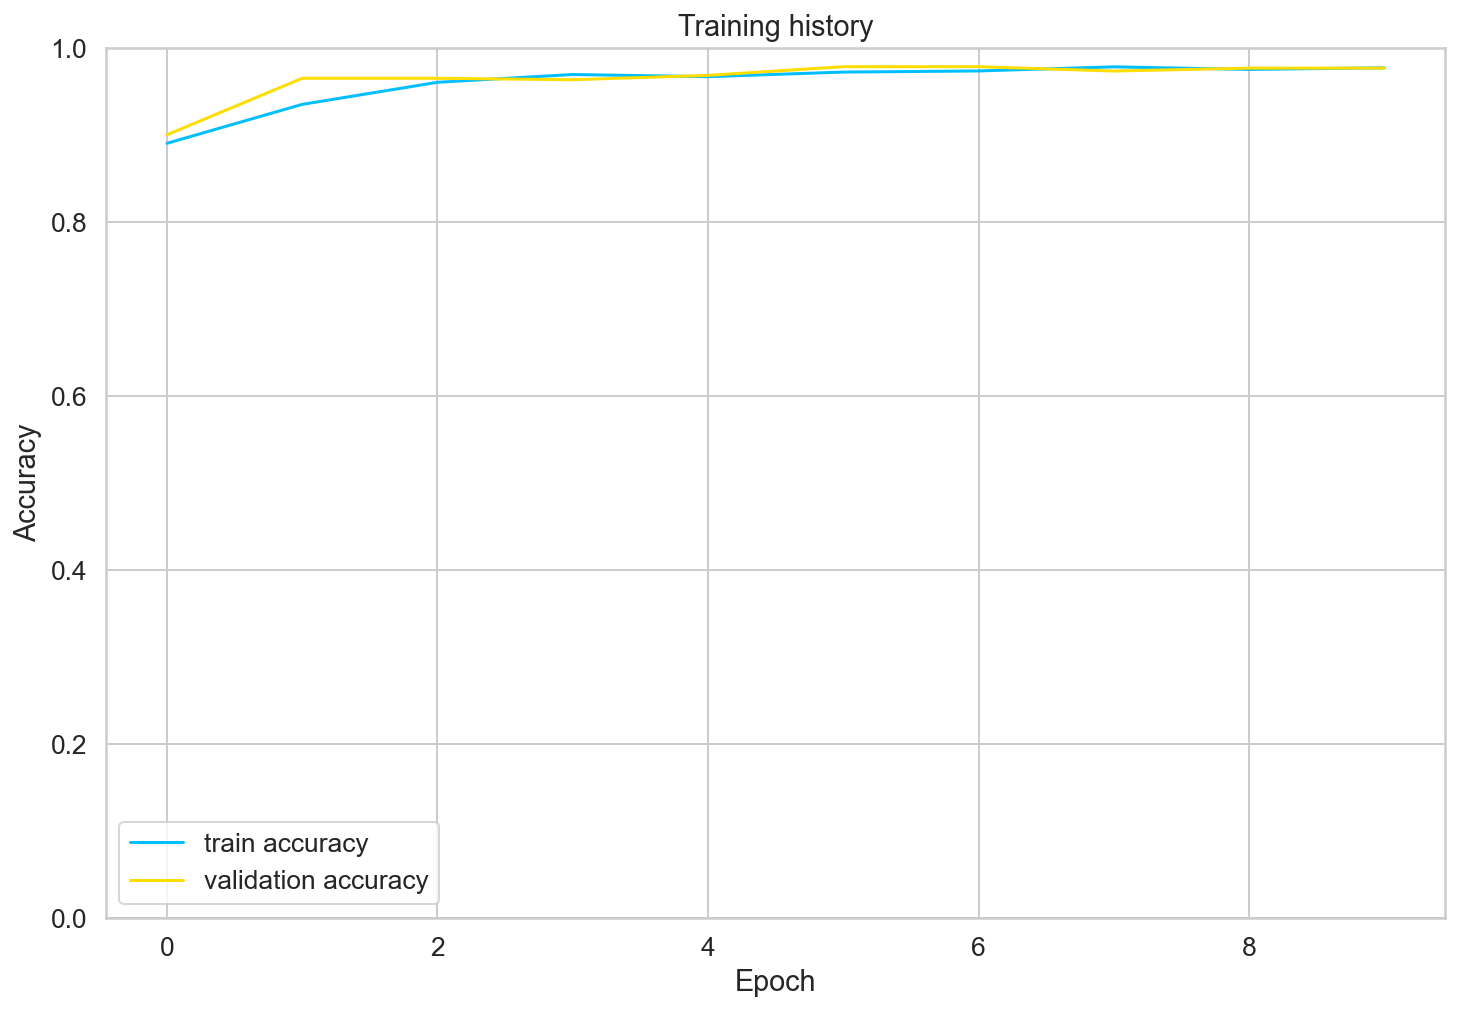

In [168]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# model = EnterpriseDangerClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## 8 模型评估

In [169]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9716666666666667

In [175]:
def get_predictions(model, data_loader):
    model = model.eval()

    raw_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1) # 类别

            probs = F.softmax(outputs, dim=1) # 概率

            raw_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return raw_texts, predictions, prediction_probs, real_values


In [176]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [178]:
print(classification_report(y_test, y_pred, target_names=[str(label) for label in class_names])) # 分类报告

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       554
           1       0.81      0.83      0.82        46

    accuracy                           0.97       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.97      0.97      0.97       600



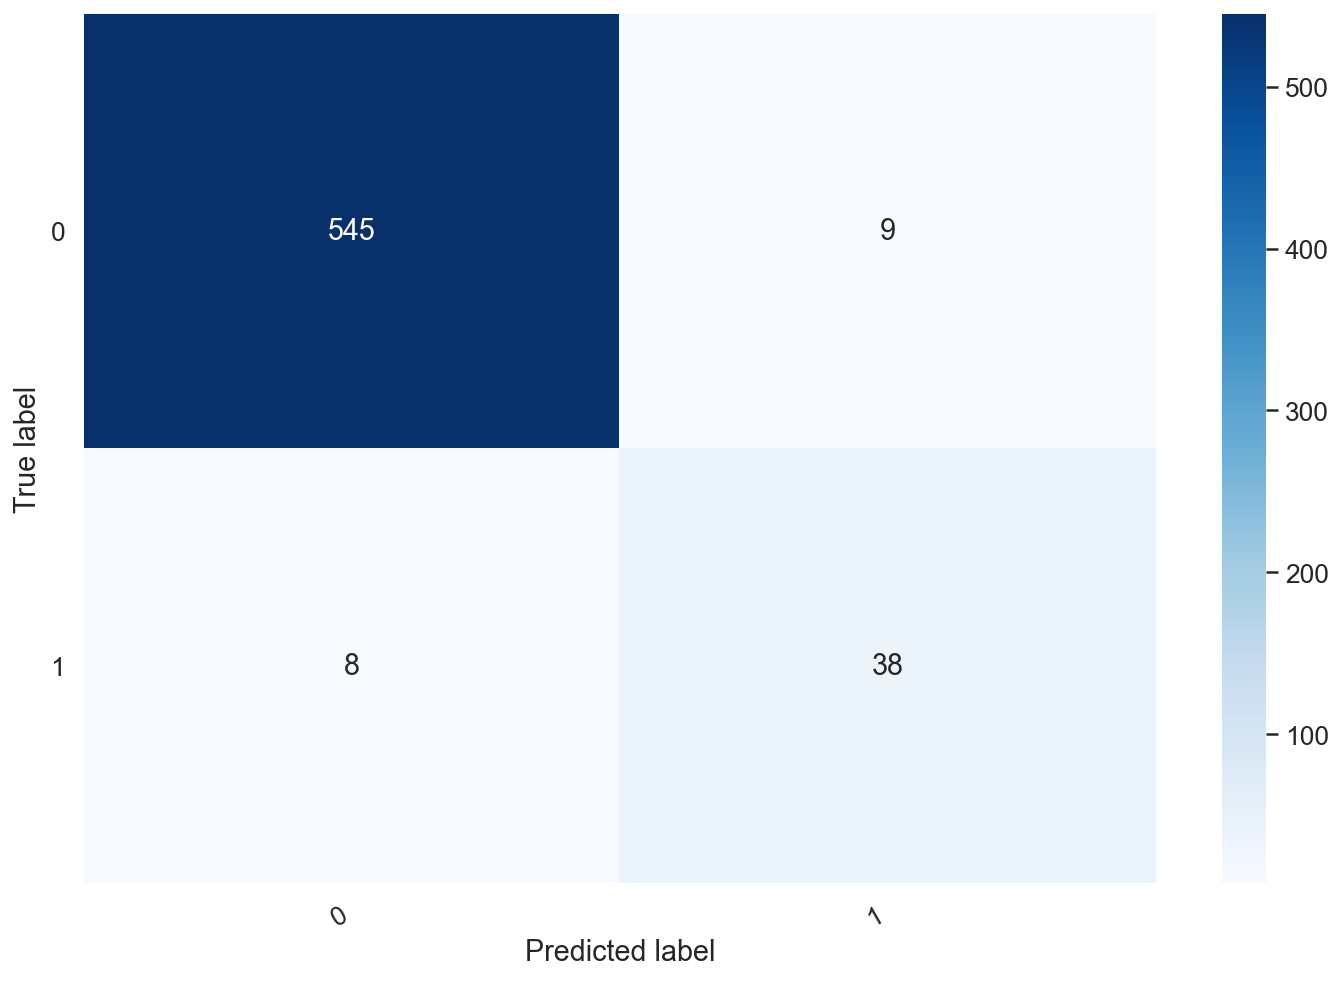

In [179]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


In [180]:
idx = 2

sample_text = y_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [181]:
print("\n".join(wrap(sample_text)))
print()
print(f'True label: {class_names[true_label]}')

焊锡员工未佩戴防护口罩 工业/危化品类 主要负责人、分管负责人及管理人员履职情况 分管负责人履职情况
分管负责人依法履行安全管理职责（存在职业健康危害的单位需自查职业卫生履职情况）。

True label: 0


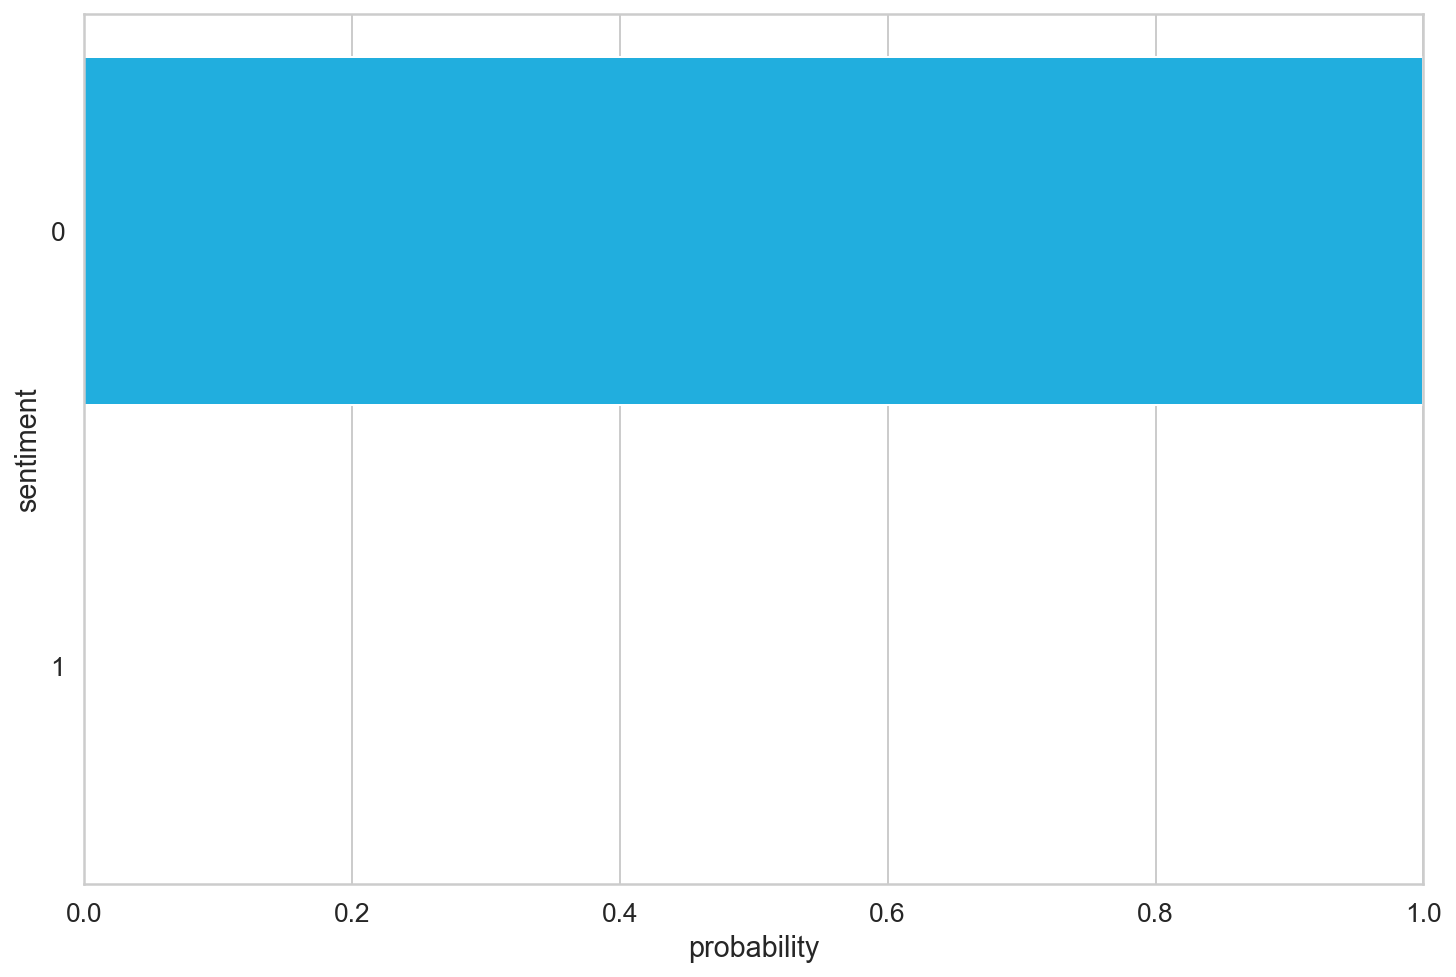

In [182]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## 9 测试集预测

In [187]:
sample_text = "电源插头应按规定正确接线"

In [188]:
encoded_text = tokenizer.encode_plus(
  sample_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [189]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Sample text: {sample_text}')
print(f'Danger label  : {class_names[prediction]}')

Sample text: 电源插头应按规定正确接线
Danger label  : 1
